<a href="https://colab.research.google.com/github/jtfreitas/NN_DL/blob/main/HW2/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q optuna
!pip install -q PyQt5
!wget -q -O vae_tools.py https://raw.githubusercontent.com/jtfreitas/NN_DL/main/HW2/vae_tools.py

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import random
from tqdm import tqdm
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision import utils as vutils
import optuna

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg
from matplotlib.ticker import MaxNLocator
from matplotlib import cm

import json
#Custom module with class definitions and model training utilities
#in order to keep notebook as procedural as possible
import vae_tools as vt

seed = 69420

# Use GPU if available
device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"Device in use: {device}")

random.seed(seed)
torch.manual_seed(seed)
print(f"Random seed: {seed}")

Device in use: cuda
Random seed: 69420


In [4]:
#Load FashionMNIST datasets into memory

data_dir = 'dataset'

train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

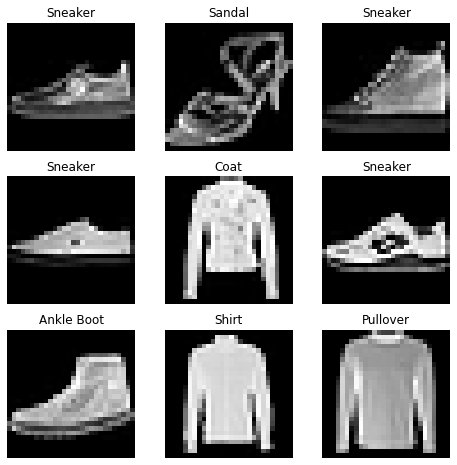

In [5]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
    }
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

In [6]:
# In this case the train_transform and test_transform are the same, 
# but we keep them separate for potential future updates
MNIST_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0, 1)
])
### Define dataloaders
train_dataloader = DataLoader(train_dataset,
                            batch_size=256, shuffle=True, num_workers=2)
test_dataloader  = DataLoader(test_dataset,
                            batch_size=256, shuffle=False)

# Include a subset used only for hyperparameter tuning to speed up process
HP_search_subset = torch.utils.data.Subset(train_dataset,
                                           list(range(len(train_dataset)//5 )))
HP_search_dataloader = DataLoader(HP_search_subset,
                                  batch_size = 120, shuffle = True)


# Set the train, test and subset transform
train_dataset.transform = MNIST_transform
test_dataset.transform = MNIST_transform
HP_search_subset.transform = MNIST_transform

# Show shapes of the data for quality control
batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


In [7]:
def AE_objective(trial):
    """
    Performs a Bayesian-like hyperparameter search, using optuna's TPESampler.
    This generally allows a more thorough search compared to completely random
    sampling methods, while saving computation time compared to a complete grid
    search, especially considering the large range of filters considered.
    Overall, it's a good compromise between the certainty of grid-search and
    the efficiency of a random search.

    The best model is chosen based on the test data loss after five epochs.
    """

    # Parameters in the search include number of filters, size of the first
    # dense layer, shape of latent space, optimizer type, and finally its 
    # respective learning rate.
    params = {
        'conv1': {'filters': trial.suggest_int('filters1', 4, 16),
                  'kernel': 3,
                  'stride': 2,
                  'padding': 1},
        'conv2': {'filters': trial.suggest_int('filters2', 16, 32),
                  'kernel': 3,
                  'stride': 2,
                  'padding': 1},
        'conv3': {'filters': trial.suggest_int('filters3', 32, 64),
                  'kernel': 3,
                  'stride': 2,
                  'padding': 0},
        'lin1': trial.suggest_int('lin1', 64, 128),
        'latent_space': trial.suggest_int('latent_space', 2, 20)
    }

    model = vt.Autoencoder(28, params, device)
    model.to(device)

    lr = trial.suggest_loguniform('lr', 1e-5, 5e-4)
    params_to_optimize = [
        {'params': model.parameters()},
    ]
    optim_type = trial.suggest_categorical(
        'optimizer', ['Adam', 'Adagrad', 'AdamW'])
    optim = getattr(torch.optim, optim_type)(params_to_optimize, lr=lr)
    loss_fn = torch.nn.MSELoss()
    best_loss = vt.train_AE(
        model, 5, HP_search_dataloader, loss_fn, optim, device, verbose=False
        )[0] 
    # Choose only the [0]th element returned by train_AE, second corresponds
    # to the training epoch of the lowest loss.

    return best_loss

In [8]:
optuna.logging.set_verbosity(optuna.logging.FATAL) # Disable optuna's verbose logging
study = optuna.create_study(direction='minimize')  # Goal is to minimize the loss
study.optimize(AE_objective, n_trials = 20)        # 20 different models are tested
best_results = study.best_trial
print(f"Best result achieved in trial {best_results.number}"
      f" with a loss of {best_results.value}"
      f"\nwith parameters:")

for key, value in best_results.params.items():
    print(f"{key} : {value}", end='\n')

with open('best_params.json', 'w') as f:
    json.dump(best_results.params, f)

Best result achieved in trial 13 with a loss of 0.02811496891081333
with parameters:
filters1 : 4
filters2 : 19
filters3 : 51
lin1 : 106
latent_space : 7
lr : 0.0004746716297396859
optimizer : AdamW


In [9]:
#Format the parameters according to the structure of the autoencoder
with open('best_params.json', 'r') as f:
    params_dict = json.load(f)
best_params = {
    'conv1': {'filters': params_dict['filters1'],
                'kernel': 3,
                'stride': 2,
                'padding': 1},
    'conv2': {'filters': params_dict['filters2'],
                'kernel': 3,
                'stride': 2,
                'padding': 1},
    'conv3': {'filters': params_dict['filters3'],
                'kernel': 3,
                'stride': 2,
                'padding': 0},
    'lin1': params_dict['lin1'],
    'latent_space': params_dict['latent_space']
}

#Instantiate the autoencoder, set up torch loss and optimizer
best_AE = vt.Autoencoder(28, best_params, device)

loss_fn = torch.nn.MSELoss()
params_to_optimize = [
    {'params': best_AE.parameters()},
]

optim = getattr(torch.optim, study.best_params['optimizer'])(
    params_to_optimize, lr=study.best_params['lr'], weight_decay=1e-5)

best_AE.to(device)
loss_fn.to(device)

MSELoss()

K-fold cross-validation

In [10]:
k_folds = 6
num_epochs = 20
cv_losses = vt.CV_AE(
    k_folds, best_AE,
    num_epochs, train_dataloader, loss_fn, optim, device)

Fold 1/6...	Done.
Fold 2/6...	Done.
Fold 3/6...	Done.
Fold 4/6...	Done.
Fold 5/6...	Done.
Fold 6/6...	Done.


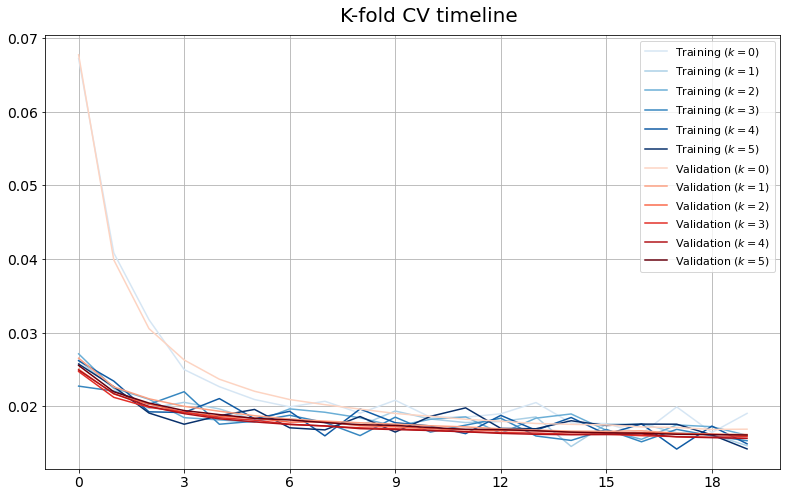

In [11]:
fig, ax = plt.subplots(1,1, figsize=(12, 7),
                       tight_layout=dict(rect=(0,0,.92,.95))
                       )

for loss, loss_type, cmap in zip(cv_losses,
                                 ['Training', 'Validation'],
                                 ['Blues', 'Reds']):
    cmap = cm.get_cmap(cmap)
    for fold in range(k_folds):
        ax.plot(range(num_epochs), loss[fold],
                color=cmap((fold+1)/k_folds),
                label=f'{loss_type} $(k={fold})$')
ax.grid()
ax.legend(loc='upper right', fontsize=11)
ax.tick_params(axis='both', labelsize=14)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
fig.suptitle('K-fold CV timeline', fontsize=20)

fig.savefig('learning_curve_KFCV.pdf')

In [12]:
def count_parameters(model):
    """
    Counts the number of trainable parameters in a model,
    based on whether they require gradients.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(best_AE)

118746

In [13]:
best_AE.reset_weights()
num_epochs = 20
vt.train_AE(
    best_AE, num_epochs, train_dataloader, loss_fn, optim, device,
    test_dataloader=test_dataloader,
    save_dir=f'models/best_AE_z{best_AE.latent_space}', verbose=True)

EPOCH 1/20 : 
partial train loss (single batch): 0.0590 Validation loss: 0.057995
EPOCH 2/20 : 
partial train loss (single batch): 0.0330 Validation loss: 0.035542
EPOCH 3/20 : 
partial train loss (single batch): 0.0277 Validation loss: 0.028238
EPOCH 4/20 : 
partial train loss (single batch): 0.0244 Validation loss: 0.024334
EPOCH 5/20 : 
partial train loss (single batch): 0.0239 Validation loss: 0.022440
EPOCH 6/20 : 
partial train loss (single batch): 0.0213 Validation loss: 0.021130
EPOCH 7/20 : 
partial train loss (single batch): 0.0204 Validation loss: 0.020146
EPOCH 8/20 : 
partial train loss (single batch): 0.0219 Validation loss: 0.019599
EPOCH 9/20 : 
partial train loss (single batch): 0.0207 Validation loss: 0.019070
EPOCH 10/20 : 
partial train loss (single batch): 0.0167 Validation loss: 0.018626
EPOCH 11/20 : 
partial train loss (single batch): 0.0185 Validation loss: 0.018175
EPOCH 12/20 : 
partial train loss (single batch): 0.0187 Validation loss: 0.018025
EPOCH 13/20 :

(tensor(0.0166), 19)

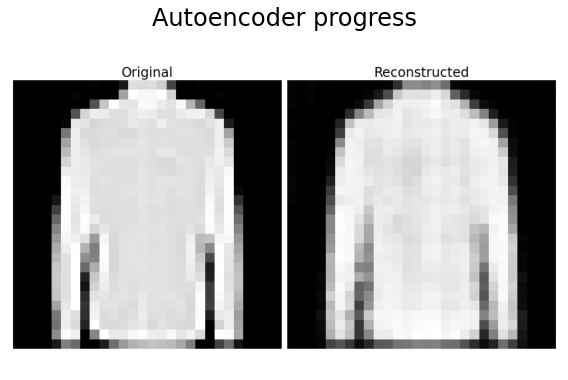

In [14]:
def read_img(i):
    """
    Handles the exception caused by plots that were not saved because the
    model performance worsened on the respective epoch.
    """
    try:
        return mpimg.imread(
            f'models/best_AE_z{best_AE.latent_space}/plots/t={i}.jpg')
    except FileNotFoundError:
        return None

fig = plt.figure(figsize=(8,6), tight_layout='pad')
fig.suptitle('Autoencoder progress', fontsize=24)
plt.axis("off")
img_list = [read_img(i) for i in range(num_epochs)]

#Checks if element in img_list is an array, skips it in case it isn't.
ims = [[plt.imshow(i, animated=True)] 
       for i in img_list if type(i) == np.ndarray]
ani = animation.ArtistAnimation(
    fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

In [15]:
with open('best_params.json', 'r') as f:
    params_dict = json.load(f)
best_params = {
    'conv1': {'filters': params_dict['filters1'],
                'kernel': 3,
                'stride': 2,
                'padding': 1},
    'conv2': {'filters': params_dict['filters2'],
                'kernel': 3,
                'stride': 2,
                'padding': 1},
    'conv3': {'filters': params_dict['filters3'],
                'kernel': 3,
                'stride': 2,
                'padding': 0},
    'lin1': params_dict['lin1'],
    'latent_space': params_dict['latent_space']
}

state_dict_best = torch.load(f'models/best_AE_{params_dict["latent_space"]}/params/t18.pth')

#Instantiate the autoencoder
best_AE = vt.Autoencoder(28, best_params, device)
best_AE.load_state_dict(state_dict_best)
best_AE.to(device)

FileNotFoundError: ignored

# Denoising

In [ ]:
#Draw random test sample
sample_idx = torch.randint(len(test_dataset), (1,))
sample, label = test_dataset[sample_idx.item()]

#Pixel-killing probabilites
p_list = [[.1,.9],[.2,.8],[.3,.7],[.4,.6],[.5,.5]]

#Set up the figure
fig, axs = plt.subplots(2, len(p_list), figsize=(11,3))

#Set up loss
losses = torch.zeros((len(p_list), 2),device=device)
loss_eval = nn.MSELoss()
loss_eval.to(device)

for i, ps in enumerate(p_list):
    sample.to(device)

    #Noise is added by zeroing pixels at random positions.
    noise_tensor = torch.from_numpy(
        np.random.choice([0,1], size=sample.size(), p=ps)
        )
    noisy_sample = sample*noise_tensor

    # Pass sample through autoencoder
    best_AE.eval()
    with torch.no_grad():
        cleanup = best_AE(noisy_sample.to(device).unsqueeze(0))
        losses[i,0] = loss_eval(noisy_sample, sample.unsqueeze(0))
        losses[i,1] = loss_eval(cleanup.cpu(), sample.unsqueeze(0))

    # Plot noisy and reconstructed sample side by side
    axs[0][i].imshow(noisy_sample.cpu().squeeze().float().numpy(), cmap='gray')
    axs[1][i].imshow(cleanup.cpu().squeeze().detach().numpy(), cmap='gray')
    axs[0][i].set_title(f'Zeroed {ps[0]*100:.0f}%\n Loss={losses[i,0].item():.3f}')
    axs[1][i].set_title(f'Loss={losses[i,1].item():.3f}')

    # Hide axis
    for ax in axs[:,i]:
        ax.axis('off')

#Aesthetic adjustments

fig.suptitle(
    f'Sample {sample_idx.item()}, {labels_map[label]}',
    fontsize=16
    )
fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.tight_layout(rect=(0,0,1,0.9),w_pad=1, h_pad=0.8)
fig.savefig('Reconstruction.pdf')
fig.show()

# Supervised learning on latent space

In [ ]:
class encoded_Dataset(torch.utils.data.Dataset):
    def __init__(self, data_list):
        self.data = data_list[0]
        self.targets = data_list[1]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (self.data[idx], self.targets[idx])


def encode_data(dataloader, AE):
    enc_list = []
    label_list = []
    for sample_batched, labels in dataloader:
        label_list.append(labels)
        with torch.no_grad():
            AE.eval()
            sample_batched = sample_batched.to(AE.device)
            latent_vectors = AE.encoder(sample_batched)
            enc_list.append(latent_vectors)
    
    encoded_tensor  = torch.cat(enc_list)
    label_tensor = torch.cat(label_list)
    return [encoded_tensor, label_tensor]


encoded_train = encode_data(train_dataloader, best_AE)
encoded_test = encode_data(test_dataloader, best_AE)
enc_train_dataset = encoded_Dataset(encoded_train)
enc_test_dataset = encoded_Dataset(encoded_test)
enc_dataloader_train = DataLoader(enc_train_dataset, batch_size=256)
enc_dataloader_test = DataLoader(enc_test_dataset, batch_size=1)

In [ ]:
import time


class_params = {
    'lin1' : (best_AE.latent_space, 20),
    'lin2' : (20, 120),
    'lin3' : (120, 100),
    'lin4' : (100, 10),
}

classifier = vt.Classifier(class_params, device)
classifier.to(device)

classifier_loss = nn.CrossEntropyLoss()
classifier_loss.to(device)
optimizer = torch.optim.Adam(
    classifier.parameters(), lr=1e-4, weight_decay=1e-5
    )
no_epochs = 50

start_time = time.time()

loss = vt.train_model(
    classifier, enc_dataloader_train, enc_dataloader_test,
    no_epochs, classifier_loss, optimizer, encoded=True, verbose=False
    )

end_time = time.time()
training_time = end_time - start_time

print(f'Training took {training_time:.2f} seconds')
print(f'Final loss: {loss:.4f}')

In [ ]:
class_params = {
    'lin1' : (28**2, 20),
    'lin2' : (20, 120),
    'lin3' : (120, 100),
    'lin4' : (100, 10),
}

classifier_noAE = vt.Classifier(class_params, device)

classifier_noAE.to(device)
classifier_noAE_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    classifier_noAE.parameters(), lr=1e-4, weight_decay=1e-5
    )
no_epochs = 50

start_time = time.time()

vt.train_model(
    classifier_noAE, train_dataloader, test_dataloader,
    no_epochs, classifier_noAE_loss, optimizer, encoded=False, verbose=False
    )

end_time = time.time()

training_time = end_time - start_time

print(f'Training took {training_time:.2f} seconds')
print(f'Final loss: {loss:.4f}')

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12, 5))
model_list = [classifier, classifier_noAE]
label_list = [('-', f'Encoding $(z={best_AE.latent_space})$'), ('--', 'No encoding')]
for label, model in zip(label_list, model_list):
    axs[0].plot(model.history['epoch'], model.history['train'],
           label[0], label=label[1])
    axs[1].plot(model.history['epoch'], model.history['valid'],
        label[0], label=label[1])
    
axs[0].set_title('Training', fontsize=16)
axs[1].set_title('Validation', fontsize=16)
fig.suptitle(f'Classifier training timeline', fontsize=20)

for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=12)

    ax.legend(fontsize=14)
    ax.grid()


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3)
pca = PCA(n_components=3)

encoded_samples = []
samples = []
for sample in test_dataset:
    samples.append(sample[0].squeeze(0).flatten().cpu().numpy())
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    best_AE.encoder.eval()
    with torch.no_grad():
        encoded_img = best_AE.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"var_{i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)

encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)
encoded_samples_reduced_TSNE = tsne.fit_transform(samples)

In [ ]:
import plotly.express as px

PCA_df = pd.DataFrame(encoded_samples_reduced_PCA, columns=['x1','x2','x3'])
PCA_df['label'] = [labels_map[label] for label in encoded_samples]

TSNE_df = pd.DataFrame(encoded_samples_reduced_TSNE, columns=['x1','x2','x3'])
TSNE_df['label'] = [labels_map[label] for label in encoded_samples]

pca_plot = px.scatter_3d(PCA_df, x='x1', y='x2', z='x3', color='label')
tsne_plot = px.scatter_3d(TSNE_df, x='x1', y='x2', z='x3', color='label')

for (img, title) in zip([pca_plot, tsne_plot], ['PCA', 't-SNE']):
    img.update_layout(
        title=title,
        height=600, width=700,
        legend={'itemsizing': 'constant',
                'font' : dict(size=14)}
        )
    img.update_traces(marker=dict(size=1.2, line=dict(width=0.7)))

In [ ]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set_theme()

fig = plt.figure(figsize=(25,9))

ax1 = fig.add_subplot(131, projection='3d')
sc1 = ax1.scatter(encoded_samples['var_0'],
               encoded_samples['var_1'],
               encoded_samples['var_2'],
               c=encoded_samples.label.to_numpy(),
            cmap="tab10", edgecolor='white', linewidths=0.5)

ax2 = fig.add_subplot(133, projection='3d')
sc3 = ax2.scatter(encoded_samples_reduced_PCA[:,0],
               encoded_samples_reduced_PCA[:,1],
               encoded_samples_reduced_PCA[:,2],
               c=encoded_samples.label.to_numpy(),
            cmap="tab10", edgecolor='white', linewidths=0.5)

ax3 = fig.add_subplot(132, projection='3d')
sc2 = ax3.scatter(encoded_samples_reduced_TSNE[:,0],
            encoded_samples_reduced_TSNE[:,1],
            encoded_samples_reduced_TSNE[:,2],
            c=encoded_samples.label.to_numpy(),
            cmap="tab10", edgecolor='white', linewidths=0.5)

ax1.set_title("Latent Space")
ax2.set_title("PCA")
ax3.set_title("t-SNE")

label_names = ['T-shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt',
             'Sneaker','Bag','Boot']

legend = fig.legend(sc1.legend_elements()[0], label_names,
                    title="Classes", loc='right',
                    fontsize=13, labelspacing=1.1)

fig.add_artist(legend)
fig.show()

In [ ]:
encoded_samples

In [ ]:
encoded_samples.plot.scatter(
    x = 'Enc. Variable 0',
    y = 'Enc. Variable 1',
    c=encoded_samples.label.to_numpy(),
    cmap='tab10', edgecolor='white', linewidths=0.5)

# Generating fake samples

In [ ]:
fake_latents = torch.randn((100, best_AE.latent_space), device=best_AE.device)
best_AE.decoder.eval()
with torch.no_grad():
    fake_samples = best_AE.decoder(fake_latents)

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(fake_samples), size=(1,)).item()
    img = fake_samples[sample_idx].cpu().detach().numpy()
    figure.add_subplot(rows, cols, i)
    # plt.title()
    plt.axis("off")
    plt.imshow(img.squeeze(0), cmap="gray")
plt.show()

# GAN

In [ ]:
n_classes = len(train_dataset.targets.unique())
params = {'latent_space' : 100,
          'G_filters' : 128,
          'D_filters' : 32,
          'n_channels' : 1,
          'opt' : 'Adam',
          'lr' : 1e-4}

gan = vt.GAN(params, device)

In [ ]:
criterion = nn.BCEWithLogitsLoss()

gan.to(device)
loss_history, img_list = vt.train_GAN(
    gan, train_dataloader, 50, criterion, device, saturating=False, snapshots = True)

In [ ]:
gan.zero_grad()
test_data = test_dataset[0][0].unsqueeze(0).to(device)
D_out = gan.netD(test_data)

label = torch.tensor([1],
                dtype=torch.float, device=device).reshape((1,1,1,1))
    

criterion(D_out, label)

In [ ]:
rand_noise = torch.randn(64, gan.latent_space, 1, 1, device=device)

gen_fakes = gan.netG(rand_noise).cpu().detach().numpy()[0]


In [ ]:
plt.imshow(gen_fakes[0], cmap= 'gist_gray')

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.title('Saturating G loss')
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), cmap='gist_gray', animated=True)] for i in gen_fakes]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

In [ ]:
class Generator(nn.Module):
    def __init__(self, params):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(params['latent_space'], params['G_filters'] * 4, 3, 2, 0, bias=False),
            nn.BatchNorm2d(params['G_filters'] * 4),
            nn.ReLU(True),
            # state size. (G_filters*8, 4, 4)
            nn.ConvTranspose2d(params['G_filters'] * 4, params['G_filters'] * 2, 3, 2, 0, bias=False),
            nn.BatchNorm2d(params['G_filters'] * 2),
            nn.ReLU(True),
            # state size. (G_filters*4, 8, 8)
            nn.ConvTranspose2d( params['G_filters'] * 2, params['G_filters'], 3, 2, 0, bias=False),
            nn.BatchNorm2d(params['G_filters']),
            nn.ReLU(True),
            # state size. (G_filters*2, 16, 16)
            nn.ConvTranspose2d( params['G_filters'], params['n_channels'], 3, 2, 2, 1, bias=False),
            nn.Tanh()
            # state size. (n_channels, 64, 64)
        )

    def forward(self, input):
        return self.main(input)

# Create the generator
netG = Generator(params).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
#netG.apply(weights_init)

# Print the model
print(netG)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, params, conditional=False):
        super(Discriminator, self).__init__()
        self.conditional=conditional
        self.main = nn.Sequential(
            # input is (1,28,28)
            nn.Conv2d(in_channels=params['n_channels'], out_channels=params['D_filters'],
                      kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (D_filters, 14, 14)
            nn.Conv2d(in_channels=params['D_filters'], out_channels=params['D_filters'] * 2,
                      kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(params['D_filters'] * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (D_filters*2, 7, 7)
            nn.Conv2d(in_channels=params['D_filters'] * 2, out_channels=params['D_filters'] * 4,
                      kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(params['D_filters'] * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (D_filters*4, 3, 3)
            nn.Conv2d(in_channels = params['D_filters']* 4, out_channels=1,
                      kernel_size = 4, stride=2, padding=1)
            # scalar output (1, 1, 1)
        )

    def forward(self, input):
        if self.conditional:
            pass

        else:
            return self.main(input)

In [ ]:
class GAN(nn.Module):
    def __init__(self, params, device, conditional=False):
        super(GAN, self).__init__()
        self.conditional = conditional
        self.latent_space = params['latent_space']
        self.netG = Generator(params)
        self.netD = Discriminator(params, conditional = self.conditional)
        self.epochs_trained = 0
        self.device = device
        
        self.optimizerD = getattr(torch.optim, params['opt'])(self.netD.params_to_optimize(), lr=params['lr'])
        self.optimizerG = getattr(torch.optim, params['opt'])(self.netG.params_to_optimize(), lr=params['lr'])


In [ ]:
# Create the Discriminator
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
netD = Discriminator(params).to(device)
img = img.to(device)
dsc_img = netD(img).detach().cpu().numpy()
img.detach()
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
# netD.apply(weights_init)

# Print the model
print(netD)
plt.imshow(dsc_img[0][0], cmap='gist_gray')

dsc_img.shape

In [ ]:
# Initialize BCELoss function
criterion = nn.BCEWithLogitsLoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, params['latent_space'], 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D

beta1 = 0.5
optimizerD = torch.optim.Adam(netD.parameters(), lr=params['lr'], betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=params['lr'], betas=(beta1, 0.999))

In [ ]:
getattr(torch.optim, "Adam")

In [ ]:
# Training Loop
# Lists to keep track of progress

num_epochs = 30
img_list = []
G_losses = []
D_losses = []
iters = 0
latent_space = params['latent_space']
saturating = False

print("Starting Training Loop...")
# For each epoch
for epoch in range(1, num_epochs+1):
    # For each batch in the dataloader
    for i, data in enumerate(train_dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label,
                           dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_space, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        if saturating:
            # Saturating loss: Use fake_label y = 0 to get J(G) = log(1−D(G(z)))
            label.fill_(fake_label)
        else:
            # Non-saturating loss: fake labels are real for generator cost
            label.fill_(real_label)

        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output

        if saturating:
            errG = -criterion(output, label)  # Saturating loss: -J(D) = J(G)
        else:
            errG = criterion(output, label)  # Non-saturating loss
        
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise

        if (iters % 500 == 0) or ((epoch == num_epochs) and (i == len(train_dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

        print(f'[{epoch}/{num_epochs}]\tLoss_D: {errD.item():.4f}, \tLoss_G: {errG.item():.4f}, \tD(x): {D_x:.4f} \tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}', end = '\r')
    print(f'[{epoch}/{num_epochs}]\tLoss_D: {errD.item():.4f}, \tLoss_G: {errG.item():.4f}, \tD(x): {D_x:.4f} \tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}', end = '\n')

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and discriminator loss")
plt.plot(G_losses,label="Non-saturating G loss", alpha=0.75)
plt.plot(D_losses,label="Non-saturating D loss", alpha=0.75)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.xscale("log")
plt.legend()
plt.show()

In [ ]:
# Visualize results with saturating G loss
fig = plt.figure(figsize=(8,8))
plt.title('Saturating G loss')
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.axis("off")
plt.title("Real images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,3,2)
plt.axis("off")
plt.title("Fake images - saturating G loss")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))

In [ ]:
# Training Loop
saturating = False
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_space, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################


        if saturating:
            label.fill_(fake_label) # Saturating loss: Use fake_label y = 0 to get J(G) = log(1−D(G(z)))
        else:
            label.fill_(real_label) # Non-saturating loss: fake labels are real for generator cost
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        
        if saturating:
            errG = -criterion(output, label) # Saturating loss: -J(D) = J(G)
        else:
            errG = criterion(output, label) # Non-saturating loss

        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1